# BBC News Classification

We'll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

In [1]:
import pandas as pd
import numpy as np

import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data input and pre-processing

We are loading this dataset locally, as a CSV file, and adding a column encoding the category as an integer (categorical variables are often better represented by integers than strings). The dataset can also be downloaded from its original source.

In [2]:
# Load data
data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')

# Use factorize to prepare the CategoryId
data['CategoryId'] = data.Category.factorize()[0]

category_df = data[['Category','CategoryId']].drop_duplicates().sort_values('CategoryId')
category2id = dict(category_df.values)
id2category = dict(category_df[['CategoryId','Category']].values)

### Data inspection

Data inspections help us understanding the data, identifying inconsistencies, assessing the data quality and informing feature engineering to create.

In [3]:
# Check the shape of the data
data.shape

# Check the column names
data.columns

# Check for missing values
data.isnull().sum()

# Look at the first few rows
data.head()

# Check the distribution of categories
data['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Base on above data inspection, we see that the data quality is good, no data cleaning is needed.

### Text preprocessing

The targte of text preprocessing is to transform raw text data into a structured format suitable for analysis or modeling, by applying techniques like tokenization, stemming, stopwords removal, and normalization, we aim to facilitate analysis, reduce dimensionality, and enhance model performance.

In [4]:
def load_stopwords():
  nltk.download('punkt')
  nltk.download('stopwords')

load_stopwords()

# Function to preprocess text
def preprocess_text(text):
  # Tokenization
  words = nltk.word_tokenize(text=text, language='english')

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # Stemming
  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]

  return ' '.join(words)

# Apply preprocessing to the 'CleanText' column
data['CleanText'] = data['Text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data exploration

Before diving head-first into training machine learning models, we should become familiar with the structure and characteristics of our dataset: these properties might inform our problem-solving approach.

A first step would be to look at some random examples, and the number of examples in each class:

In [5]:
data.sample(5, random_state=0)

,ArticleId,Text,Category,CategoryId,CleanText
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4,focker fuel festiv film chart comedi meet fock...
354,1349,tory candidate quits over remark a conservativ...,politics,2,tori candid quit remark conserv elect challeng...
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3,bath face tindal ultimatum mike tindal agent w...
907,1155,chancellor rallies labour voters gordon brown ...,politics,2,chancellor ralli labour voter gordon brown iss...
575,307,young debut cut short by ginepri fifteen-year-...,sport,3,young debut cut short ginepri fifteen-year-old...


Show the number of documents per category:

<Axes: xlabel='Category'>

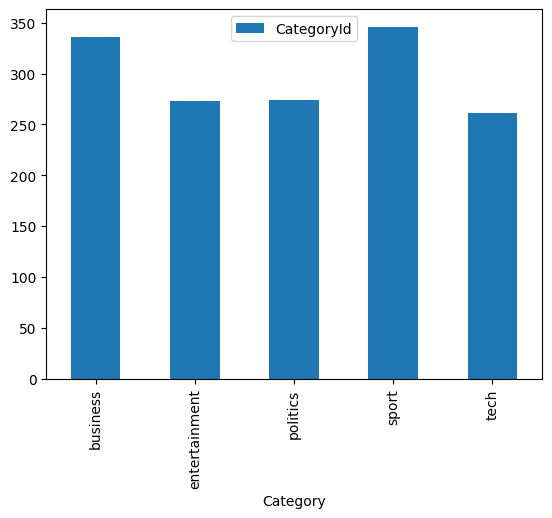

In [6]:
data[['Category','CategoryId']].groupby('Category').count().plot.bar(ylim=0)

Here, we see that the number of articles per class is roughly balanced, which is great! If our dataset were imbalanced, we would need to carefully configure our model or artificially balance the dataset.

Show the Word Cloud of the articles:

(-0.5, 799.5, 399.5, -0.5)

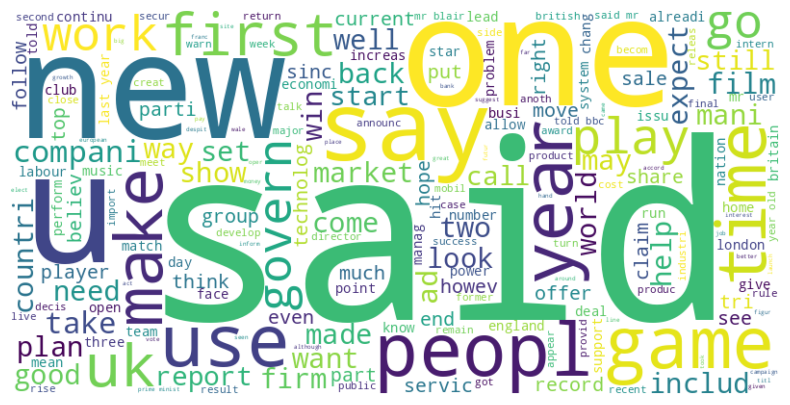

In [22]:
text = ' '.join(data['CleanText'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

By observing the Word Could picture, we know that:
- High-frequency function words: words like "said", "say", "one", "people" are common used function words in English.
- Specific topic: words like "film", "govern", "company" are consider specific topic such as entainment or political topics.

Show the Word Frequency of the articles:

In [23]:
def get_word_counts(text_data):
  all_words = []
  for text in text_data:
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    all_words.extend(words) 
  word_counts = Counter(all_words)
  word_freq = pd.DataFrame({'word': list(word_counts.keys()), 'count': list(word_counts.values())})
  word_freq = word_freq.sort_values(by='count', ascending=False)
  return word_freq

word_freq = get_word_counts(data['CleanText'])
word_freq.head(20)

,word,count
75,said,4838
39,mr,2006
112,year,1853
160,would,1711
83,also,1426
65,new,1334
286,peopl,1324
27,us,1234
384,one,1190
336,say,1050


Based on above Word Frequency data, the observations are:
- Common function words: words likes "said", "would", "also", "could" are common function words used in language.
- Potential topics: words like "people," "government," "time," and "year" suggest a focus on social or political topics.
- Specific domains: terms like "game," "film," and "tech" (if present) might indicate a specific domain or subject matter.

## Building and training models

### Feature Extraction

In order to analysis our dateset with Machine Learning methods, we need to transform each article's text to a feature vector. Use the [TF-IDF (Term Frequency-Inverse Document Frequency)]() to capture the importance of words within a document and across the entire dataset, This will creates a document-term matrix where rows represent documents and columns represent unique words:

In [9]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = vectorizer.fit_transform(data.Text).toarray()
features.shape

(1490, 5000)

### Non-Negative Matrix Factorization (NMF)

Apply NMF to the document-term matrix. NMF decomposes the matrix into two lower-dimensional matrices:
- W: A document-topic matrix, where each row represents a document and each column represents a topic. The values in this matrix indicate the weights (or contributions) of each topic to a particular document.
- H: A topic-term matrix, where each row reprents a topic and each column rpresents a word. The values in this matrix indicate the importance of each word for describing a particular topic.

Here we create NMF model with `n_components=5` and `random_state=42`, we'll update some of the hyperparameters later to improve the predict accuracy.

In [10]:
# Define the number of topics
num_topics = 5

# Training the NMF model
nmf = NMF(n_components=num_topics, random_state=42)
topic_matrix = nmf.fit_transform(features)

Analyze the `H` matrix (topic-term matrix) to understand the discovered topics. Words with high values in a specific column of `H` are most relevant to that particular topic, here we use the `argmax()` function to identify the particular topic.

In [11]:
# Assign topics to articles
data['predicted_topic'] = topic_matrix.argmax(axis=1)

As we see, the factorize() function assigns integer labels starting from 0 to n-1 for n unique labels, while the NMF topics are also numbered from 0 to n-1. However, these two sets of numbers don't necessarily align. Let's modify our approach to align them better.

In [12]:
# Align NMF topics with given labels
def alignTopicToLabel():
    topic_to_label = {}
    for topic in range(num_topics):
        labels = data[data['predicted_topic'] == topic]['CategoryId']
        if len(labels) > 0:
            topic_to_label[topic] = labels.mode().iloc[0]
        else:
            topic_to_label[topic] = -1  # Assign -1 if no articles in this topic
    return topic_to_label
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)

This approach aligns the NMF topics with the encoded labels based on the most frequent label in each topic. It allows for a more meaningful comparison between the discovered topics and the true labels.
Also, this alignment is a post-hoc interpretation of the NMF results. The equality of this alignment depends on how well the discovered topics correspond to the true categories.

Next, we can discover each topic represents by analysis the nmf components. By looking at the most important words, we can interpret and label the topics in a human-readable way. This is especially valuable in unsupervised learning scenarios where we don't have predifined labels or categories.

In [13]:
# Get the most important words for each topic
feature_names = vectorizer.get_feature_names_out()
word_importance = nmf.components_

for topic_idx, topic in enumerate(word_importance):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]
    topic_name = id2category[topic_to_label[topic_idx]]
    print(f"Topic {topic_name}: {', '.join(top_words)}")

Topic tech: people, users, technology, mobile, digital
Topic sport: game, win, england, cup, team
Topic politics: mr, labour, election, blair, party
Topic entertainment: film, best, awards, actor, award
Topic business: growth, said, market, economy, year


Based on above top words analysis, the NMF model seems to have successfully identified distinct topics, so that we can leverage this approach to analysis the test dataset.

## Model Evaluation

Evaluating model performance is a crucial step in machine learning, it helps us assess how well our model generalizes to unseen data and achieves the desired outcome. The scikit-learn classification_report function offers several benefits for evaluating performance of a classification model:
+ It provides a detailed breakdown of the model's performance for each class in a multi-class classification problem. This includes **Precision**, **Recall**, **F1-score**, and **Support**.
+ It calculate macro and weighted averages of these metrics, offering a summary of the model's overall performance across all classes.

In [14]:
target_names = data.Category.unique()
print("\nClassification Report:")
print(classification_report(data.CategoryId, data['aligned_topic'], target_names=target_names))


Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.97      0.95       336
         tech       0.92      0.93      0.93       261
     politics       0.96      0.95      0.95       274
        sport       0.95      0.99      0.97       346
entertainment       0.98      0.88      0.92       273

     accuracy                           0.95      1490
    macro avg       0.95      0.94      0.94      1490
 weighted avg       0.95      0.95      0.95      1490



Based on above classification report, we know that:
+ The accuracy of 0.95 indicates that the model correctly classified 95% of the documents.
+ The macro and weighted avarages for precision, recall and F1-score are all around 0.95, suggesting consistent performance across all categories.
+ For the individual classes, all categories have precision, recall and F1-score above 0.90, indicating good performance for each topic. 
  + "Sport" category has the highest recall (0.99) suggesting the model rarely misses relevant sport articles.
  + "Business" has the lowest precision (0.93) meaning there might be a few false positive in this category.

We see misclassifying in the above report, by visualizing the confusion matrix, we can identify how many article were correctly classified for each category and how many were misclassified into other categories, it helps identify common mistakes made by the model. Also, as we knoe, the rows represent the actual classes (as labeled in data), columns represent the predicted classes by the NMF model, and the diagonal elements represent correctly classified articles, the off-diagonal elements represent misclassified documents.

Text(95.72222222222221, 0.5, 'True Labels')

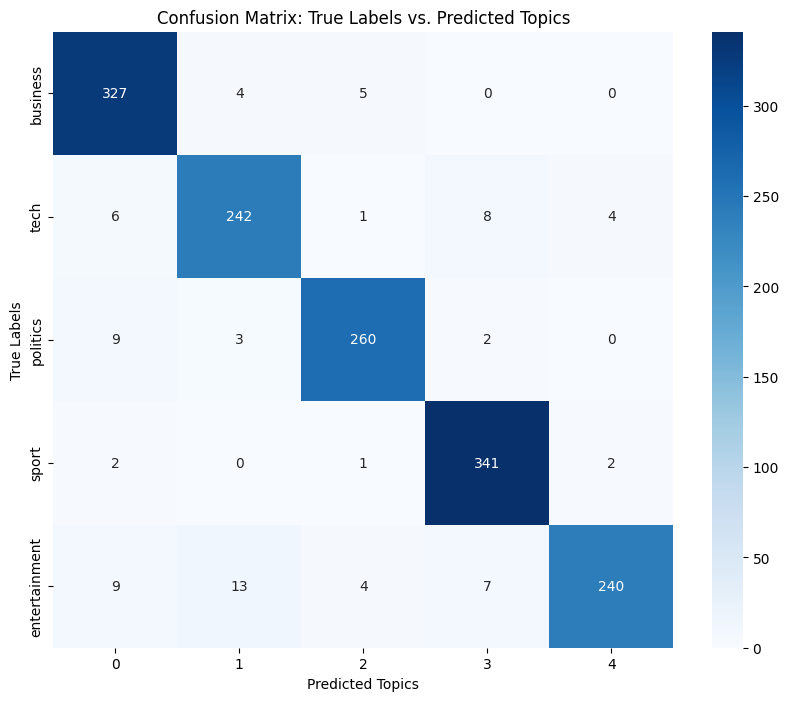

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(data.CategoryId, data['aligned_topic']), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_topics), yticklabels=target_names)
plt.title('Confusion Matrix: True Labels vs. Predicted Topics')
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

Overall, the model performs well with a high number of correct classifications on the dianonal, for some of the individual classes:
- Sport: This category has the highest number of correctly classified documents (341) and very few misclassifications, suggesting the model is very good at identifying sports articles.
- Entertainment: This category has a similar number of correct classifications (246) as sport, but with more misclassifications, particularly with tech and business. The model might struggle to distinguish some entertainment articles from these categories.

## Model Tuning

By examining the top words, we can assess whether we need to adjust our model parameters (e.g., number of topics, init method) or preprocessing steps (e.g., stop words, n-grams) to improve the quality of the topics.

Let's update some of the NMF hyperparameters and check the accuracy_score:

In [16]:
# Here we set init method as 'random' and set solver method as 'mu'
nmf = NMF(init='random', n_components=num_topics, random_state=42, solver='mu')
topic_matrix = nmf.fit_transform(features)
data['predicted_topic'] = topic_matrix.argmax(axis=1)
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)
nmf_accuracy = accuracy_score(data.CategoryId, data['aligned_topic'])
# We will use nmf_accuracy to compare the nmf accuracy with the supervised learning models later
nmf_accuracy

0.9489932885906041

After modifying the model hyperparameters, the accuracy score 0.9490 indicates it has been slighely improved, it also means that it is very difficult to continue to improve the accuracy when the accuracy is already high.

## Supervised Learning Models

Here, we will use benchmark the following models:
- **Logistic Regression**: Logistic Regression is a statistical method for predicting the probability of a binary outcome based on one or more independent variables. It's often used for classification tasks, as it can be extended to multi-class problems. Logistic Regression models the relationship between the features and the probability of belonging to a particular class using a logistic function.
- **Naive Bayes**: Naive Bayes is a probabilistic classifier based on Bayes' theorem with a strong independence assumption between features. It's simple to implement and works well with text classification problems. Naive Bayes calculates the probability of each class based on the given features and assigns the class with the highest probability.
- **SVM**: Support Vector Machine aims to find the optimal hyperplane that separates data points into different classes. SVMs are particularly effective for complex classification tasks with clear margins of separation between classes. They can handle both linear and non-linear data through kernel functions.

To evaluate each of above model, we will use the cross-validation technique: it involves splitting the dataset into multiple subsets, training the model on different subsets, and evaluating it on the remaining subset.

The sklearn provided `cross_val_score` function is a valuable tool for obtaining a reliable estimate of a model's performance on unseen data. It helps to avoid overfitting, save time, and provides flexibility in evaluating different performance metrics.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='model_name', ylabel='accuracy'>

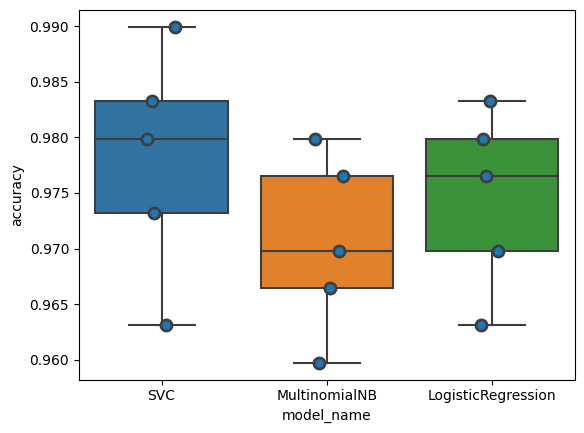

In [17]:
labels = data.CategoryId

models = [SVC(kernel='linear', gamma=5),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append([model_name, fold_idx, accuracy])
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

This boxplot compares the cross-validation accuracy scores for three different machine learning models: SVC (Support Vector Classifier), MultinomialNB (Multinomial Naive Bayes), and Logistic Regression. We can see all three models perform well, with median accuracies above 0.97, the SVC model appears to be the most accurate and consistent for this particular dataset and cross-validation setup.

### NMF Model vs. Supervised Learing Models

In [18]:
cv_df.loc[len(cv_df)] = ["NMF", 0, nmf_accuracy]
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.974497
MultinomialNB         0.970470
NMF                   0.948993
SVC                   0.977852
Name: accuracy, dtype: float64

Based on the above results, we can observe that:
- The supervised learning models have very similar, high accuracy scores, ranging from 0.9704 to 0.9778, the NMF model has a significantly lower accuracy score of 0.9490.
- The overall high accuracy scores suggest that the models are performing well on given dataset.
- The small differences in accuracy between supervised learning models might not to be statistically significant.
- The NMF model is typically used for dimensionality reduction and topic modeling, not classification. Its poor performance in this context is expected.

## Predict Test Dataset

Base on above accuracy benchmark, we could select the SVC model to predict the test dataset, let's create the SVC model with the GridSearch searched best hyperparameters and then predict the test dataset.

In [21]:
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(features)
y_train = data.CategoryId

# Create the SVC model with GridSearchCV searched best parameters(finished running offline)
svc = SVC(C = 0.1, kernel='linear', gamma=5, random_state=42)

# Fit the grid search to the data
svc.fit(X_train, y_train)

# Extract test features from test dataset
features_test = vectorizer.fit_transform(data_test.Text).toarray()

# Make predictions on the test set
features_test = scaler.transform(features_test)
category_ids = svc.predict(features_test)

# Convert each category id to category name
categories = [id2category[id] for id in category_ids]
# Create test set prediction file
final_dict = {"ArticleId": data_test.ArticleId, "Category":categories}
final_df = pd.DataFrame(final_dict)
final_df.to_csv('submission.csv',index=False)

final_df.head()

,ArticleId,Category
0,1018,sport
1,1319,politics
2,1138,entertainment
3,459,tech
4,1020,sport
